# Hessian/Covariance Calculation in Minuit (with internal transforms)

tldr: At the minimum hessians transform under change of variable covariantly (i.e. we can compute the Hessian in the bounded variables just as a transform of the Hessian in MINUITs internal unbounded variable). But this only holds at the minimum of the function - MINUIT exploits that.

This is a short notebook discussing how Minuit computes covariances and Hessians.

Minuit uses a parameter transformation to map a bounded variable to an unbounded one: $x\in[a,b]\to n\in[-\infty, \infty]$

where the transform is from e$x$ternal variabels to i$n$ternal variables is given by 

$$n(x) = \arcsin\left(2\frac{(x-a)}{b-a} - 1\right)$$

with the inverse being

$$x(n) = a+ \frac{(b-a)}{2}\sin(n) + 1$$




In [159]:
import jax
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def to_bounded(n,bounds):
    a,b = bounds
    return a+0.5*(b-a)*(jnp.sin(n) + 1)

def to_inf(x,bounds):
    a,b = bounds
    return jnp.arcsin(2*(x-a)/(b-a)-1)

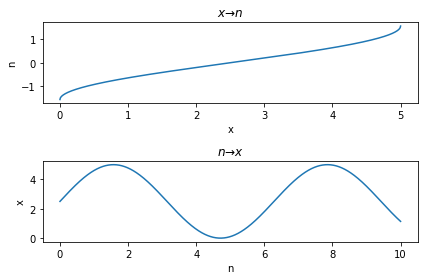

In [160]:
def plot_trfs():
    bounds = [0,5]

    f,axarr = plt.subplots(2,1)

    x = jnp.linspace(bounds[0],bounds[1],1001)
    n = jax.vmap(to_inf,in_axes=(0,None))(x,bounds)
    ax = axarr[0]
    ax.plot(x,n)
    ax.set_xlabel('x')
    ax.set_ylabel('n')
    ax.set_title(r'$x \to n$')

    n = jnp.linspace(0,10,1001)
    x = jax.vmap(to_bounded,in_axes=(0,None))(n,bounds)

    ax = axarr[1]
    ax.plot(n,x)
    ax.set_xlabel('n')
    ax.set_ylabel('x')
    ax.set_title(r'$n \to x$')
    f.set_tight_layout(True)
plot_trfs()

In [161]:
def func(external_pars):
    x,y = external_pars
    # a,b = 2*x+y,x-y
    a,b = x,y
    ca,cb = 1,1
    z = (a-ca)**2 + (b-cb)**2
    return z
    
    
def internal_func(internal_pars,bounds):
    external_pars = jax.vmap(to_bounded)(internal_pars,bounds)
    return func(external_pars)

bounds = jnp.array([[-5,5],[-5,5]])



def plot_func(ax,func,slices,bounds = None):
    grid = x,y = np.mgrid[slices[0],slices[1]]
    X = jnp.swapaxes(grid,0,-1).reshape(-1,2)

    if bounds is not None:
        Z = jax.vmap(func,in_axes=(0,None))(X,bounds)
    else:
        Z = jax.vmap(func)(X)
    z = jnp.swapaxes(Z.reshape(101,101),0,-1)
    ax.contourf(x,y,z,levels = 100)
    ax.contour(x,y,z,levels = 10, colors = 'w')
    ax.set_xlabel(r'$n_1$')
    ax.set_xlabel(r'$n_2$')
    if bounds is not None:
        rect = patches.Rectangle([-np.pi/2,-np.pi/2],np.pi,np.pi, alpha = 0.2, facecolor = 'k')
        ax.add_patch(rect)

def angle_and_lam(M):
    lam,bases = jnp.linalg.eig(M)
    first = bases[:,0]
    sign =  jnp.sign(first[2])
    angle = jnp.arccos(first[0])*180/np.pi
    return lam,sign*angle

def draw_covariances(ax,func,slices,bounds = None,scale = 1):
    grid = x,y = np.mgrid[slices[0],slices[1]]
    X = np.swapaxes(grid,0,-1).reshape(-1,2)

    if bounds is not None:
        covariance = lambda X,bounds: jnp.linalg.inv(jax.hessian(func)(X,bounds))
        args = (X,bounds)
        axes = (0,None)
    else:
        covariance = lambda X: jnp.linalg.inv(jax.hessian(func)(X))
        args = (X,)
        axes = (0,)
    lams,angles = jax.vmap(angle_and_lam)(jax.vmap(covariance,in_axes=axes)(*args))
    for i,(lam,angle) in enumerate(zip(lams,angles)):
        e = patches.Ellipse(
            X[i],np.sqrt(lam[0])*scale,np.sqrt(lam[1])*scale,angle,
            alpha = 0.5,
            facecolor = 'none',
            edgecolor = 'k'
        )
        ax.add_patch(e)
    ax.set_xlim(slices[0].start,slices[0].stop)
    ax.set_ylim(slices[0].start,slices[0].stop)    


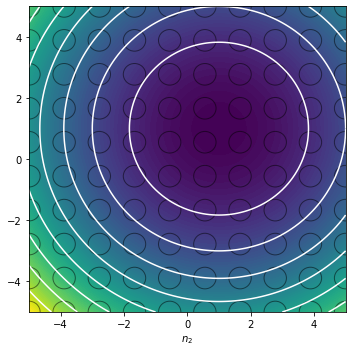

In [162]:
f,ax = plt.subplots(1,1)
f.set_size_inches(5,5)
f.set_tight_layout(True)
plot_func(ax, func, slices = [
        slice(-5,5,101*1j),
        slice(-5,5,101*1j)
    ])

draw_covariances(ax,func,slices = [
        slice(-5,5,10*1j),
        slice(-5,5,10*1j)
    ],
    scale = 1
)    


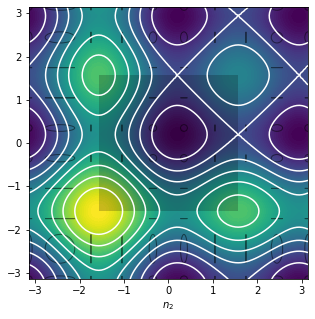

In [163]:
f,ax = plt.subplots(1,1)
f.set_size_inches(5,5)

plot_func(ax,internal_func,slices = [
        slice(-np.pi,np.pi,101*1j),
        slice(-np.pi,np.pi,101*1j)
    ],bounds = bounds)
bounds = jnp.array([[-5,5],[-5,5]])
draw_covariances(ax,internal_func,slices = [
        slice(-np.pi,np.pi,10*1j),
        slice(-np.pi,np.pi,10*1j)
    ],
    bounds = bounds,
    scale = 1
)


# Transforming the Hessian

We're interested in how the Hessian Matrix (or its inverse, the covariance matrix) transforms under variable change. As the matrix elements in the Hessian are a *second order* derivative, the matrix does in general *not* transform linearly by attaching Jacobian factors to it:

$$
\begin{align}
\frac{\partial^2}{\partial x_i \partial x_j} f &= \frac{\partial}{\partial x_i}\bigg(\frac{\partial}{\partial x_j} \bigg (f \bigg) \bigg)
\end{align}
$$

under a Jacobian transform

$$\frac{\partial}{\partial x_i} \to \sum_k \frac{\partial y_k}{\partial x_i}\frac{\partial}{\partial y_k} = J_{ik} \frac{\partial}{\partial y_k}$$ 


$$
\begin{align}
\frac{\partial^2}{\partial x_i \partial x_j} f &= \frac{\partial}{\partial x_i}\left(\frac{\partial}{\partial x_j}\bigg(f \bigg) \right)\\
&= J_{ik}\frac{\partial}{\partial y_k}\left(J_{jl}\frac{\partial}{\partial y_l}\bigg(f \bigg) \right)\\
&= J_{ik}\frac{\partial J_{jl}}{\partial y_k}\frac{\partial f}{\partial y_l} + J_{ik} J_{jl}  \frac{\partial^2 f}{\partial y_k \partial y_l} \\
(H_x)_{ij} &= J_{ik}\frac{\partial J_{jl}}{\partial y_k}\frac{\partial f}{\partial y_l} + J_{ik}  (H_y)_{kl} J^T_{lj} \\
\end{align}
$$

at the minimum, where $\frac{\partial f}{\partial y_l} = 0$

we have

$$\frac{\partial^2}{\partial x_i \partial x_j} f |_{\frac{\partial f}{\partial y_l} = 0} = J_{ik}  \frac{\partial^2 f}{\partial y_k \partial y_l} J^T_{lj}  $$


since we have element-wise transforms $J_{ik}  = g_i \delta_{ik} = \frac{\partial y_i}{\partial x_i}$ and thus 

$$\frac{\partial^2}{\partial x_i \partial x_j} f |_{\frac{\partial f}{\partial y_l} = 0} = g_{i}  \frac{\partial^2 f}{\partial y_i \partial y_j} g_{j} $$


and with the inverse being $(A B C)^{-1} = C^{-1}B^{-1} A^{-1}$ we get 

$$\mathrm{cov}_{x_i,x_j} =  \frac{\partial x_j}{\partial y_j}  \cdot \mathrm{cov}_{y_i,y_j} \cdot    \frac{\partial x_i}{\partial y_i}$$


as is computed here: 

https://root.cern.ch/doc/master/classROOT_1_1Minuit2_1_1MnUserTransformation.html#a10f2146be0a2c991243dd2f70a943a15


Let's try to demonstrate this with JAX

Heres the function to compute the Jacobian as a function of the internal parameters: $y \mapsto J_{ij}(x(y))$

In [164]:
def grads_from_n(n):
    x = jax.vmap(to_bounded)(n,bounds)
    J = jax.jacfwd(jax.vmap(to_inf))(x,bounds)
    return J

Now we comute the expression above.

In the first summand $a$ there are three terms: 
* The Jacobian $J_{ik}$
* The derivative of the Jacobian wrt $y$: $\partial J_{jl}/\partial y_k$
* The gradient of the function wrt to the internal coordinates $y$: $\partial f/\partial y_l$

The second summand $b$: has

* two jacobian factors
* the internal Hessian $H_y = \partial^2 f/\partial y_k\partial y_l$

we then use the convenient einstein summation to compute the contractions

In [165]:
def hessian_transform(extr,bounds):
    intr = jax.vmap(to_inf)(extr,bounds)

    first = jax.jacfwd(jax.vmap(to_inf))(extr,bounds)  
    secnd = jax.jacfwd(grads_from_n)(intr)
    third = jax.grad(internal_func)(intr,bounds)

    J = jax.jacfwd(jax.vmap(to_inf))(extr,bounds)

    a = jnp.einsum('ik,kjl,l->ij',first,secnd,third)

    int_hessian = jax.hessian(internal_func)(intr,bounds)
    b = jnp.einsum('ik,jl,kl->ij',J,J,int_hessian)
    return int_hessian,a,b,a+b

At the minimimum we see that the first part $a$ vanishes and the external Hessian can simply be computed as a transform of the internal hessian

In [166]:
def check_point(extrn,bounds):
    int_hessian,a,b,extrn_hessian = hessian_transform(extrn,bounds)

    print(f'internal hessian:\n{int_hessian}')
    print(f'additional part:\n{a}')
    print(f'transformed internal hessian:\n{b}')
    print(f'reproduced external hessian:\n{extrn_hessian}')

    direct_hessian = jax.hessian(func)(extrn)
    print(f'directly computed hessian:\n{direct_hessian}')

bounds = jnp.array([[-5,5],[-5,5]])
extrn = jnp.array([1.,1.])
check_point(extrn,bounds)

internal hessian:
[[47.999996  0.      ]
 [ 0.       47.999996]]
additional part:
[[0. 0.]
 [0. 0.]]
transformed internal hessian:
[[2. 0.]
 [0. 2.]]
reproduced external hessian:
[[2. 0.]
 [0. 2.]]
directly computed hessian:
[[2. 0.]
 [0. 2.]]


While at any other point,m the transformed Hessian does not correctly reproduce the external Hessianm

In [167]:
extrn = jnp.array([2.,2.])
check_point(extrn,bounds)

internal hessian:
[[38.000004  0.      ]
 [ 0.       38.000004]]
additional part:
[[0.19047618 0.        ]
 [0.         0.19047618]]
transformed internal hessian:
[[1.8095242 0.       ]
 [0.        1.8095242]]
reproduced external hessian:
[[2.0000005 0.       ]
 [0.        2.0000005]]
directly computed hessian:
[[2. 0.]
 [0. 2.]]


In [168]:
def compare(ax,scale = 2, index = -1, color = 'k'):
    slices = [slice(-5,5,11j),slice(-5,5,11j)]

    grid = x,y = np.mgrid[slices[0],slices[1]]
    X = np.swapaxes(grid,0,-1).reshape(-1,2)
    covariance = lambda X,bounds: hessian_transform(X,bounds)[index]
    args = (X,bounds)
    axes = (0,None)

    covariances = jax.vmap(covariance,in_axes=axes)(*args)

    lams,angles = jax.vmap(angle_and_lam)(covariances)
    for i,(lam,angle) in enumerate(zip(lams,angles)):
        e = patches.Ellipse(
            X[i],lam[0]*scale,lam[1]*scale,angle,
            alpha = 0.5,
            facecolor = 'none',
            edgecolor = color
        )
        ax.add_patch(e)
    ax.set_xlim(slices[0].start,slices[0].stop)
    ax.set_ylim(slices[0].start,slices[0].stop)        

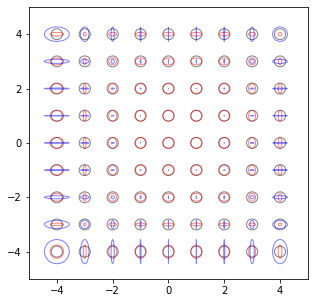

In [169]:
f,ax = plt.subplots(1,1)
compare(ax,scale = 0.2, index = -1)
compare(ax,scale = 0.2, index = -2, color = 'r')
compare(ax,scale = 0.2, index = -3, color = 'b')
plt.gcf().set_size_inches(5,5)